# Heart Failure Prediction - Model Interpretation with SHAP

This notebook provides interpretable insights into the best model using SHAP (SHapley Additive exPlanations).

**What we'll do:**
1. Load the best trained model
2. Generate SHAP summary plot (global feature importance)
3. Generate SHAP waterfall plot (individual prediction explanation)
4. Generate SHAP dependence plots
5. Save SHAP explainer object for dashboard use

**SHAP Benefits:**
- Understand which features drive predictions
- Explain individual predictions
- Identify feature interactions
- Build trust in the model


## 1. Import Libraries


In [1]:
# Data manipulation
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model and preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib

# SHAP for model interpretation
import shap

# Utilities
import os
from datetime import datetime

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("All libraries imported successfully!")
print(f"SHAP version: {shap.__version__}")


✓ All libraries imported successfully!
SHAP version: 0.46.0
Timestamp: 2025-12-01 13:56:28


## 2. Load Data and Model


In [2]:
# Load the original dataset
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')

# Separate features and target
X = df.drop('DEATH_EVENT', axis=1)
y = df['DEATH_EVENT']

# Perform train-test split (same as in training notebook)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# Load the scaler and scale the data
scaler = joblib.load('models/scaler.pkl')
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to DataFrames for better visualization
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

print("Data Loaded Successfully:")
print("=" * 60)
print(f"Training samples: {len(X_train_scaled)}")
print(f"Test samples: {len(X_test_scaled)}")
print(f"Number of features: {X_train_scaled.shape[1]}")
print(f"\nFeatures: {list(X.columns)}")


Data Loaded Successfully:
Training samples: 239
Test samples: 60
Number of features: 12

Features: ['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time']


In [3]:
# Load the best model
best_model = joblib.load('models/best_model.pkl')

# Load model comparison to identify which model was selected
comparison_df = pd.read_csv('models/model_comparison.csv')
best_model_name = comparison_df.loc[comparison_df['Test ROC-AUC'].idxmax(), 'Model']
best_model_auc = comparison_df['Test ROC-AUC'].max()

print("\nBest Model Loaded:")
print("=" * 60)
print(f"Model: {best_model_name}")
print(f"Test ROC-AUC: {best_model_auc:.4f}")
print(f"Model type: {type(best_model).__name__}")
print("\n Model ready for interpretation!")



Best Model Loaded:
Model: Random Forest
Test ROC-AUC: 0.9089
Model type: RandomForestClassifier

✓ Model ready for interpretation!


## 3. Create SHAP Explainer


In [4]:
print("Creating SHAP Explainer")
print("=" * 60)

# Create appropriate explainer based on model type
# For tree-based models (RandomForest, XGBoost, LightGBM), use TreeExplainer
# For linear models (LogisticRegression), use LinearExplainer

model_type = type(best_model).__name__

if 'Forest' in model_type or 'XGB' in model_type or 'LGBM' in model_type:
    print(f"Using TreeExplainer for {model_type}...")
    explainer = shap.TreeExplainer(best_model)
    shap_values_raw = explainer.shap_values(X_test_scaled)
    
    print(f"Raw SHAP values type: {type(shap_values_raw)}")
    if isinstance(shap_values_raw, list):
        print(f"SHAP values is a list with {len(shap_values_raw)} elements")
        print(f"Shape of each element: {[sv.shape for sv in shap_values_raw]}")
    else:
        print(f"SHAP values shape: {shap_values_raw.shape}")
    
    # Handle different return formats
    if isinstance(shap_values_raw, list):
        # List format: [class_0_values, class_1_values]
        shap_values = shap_values_raw[1]  # Use positive class (death=1)
        expected_value = explainer.expected_value[1] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value
    elif len(shap_values_raw.shape) == 3:
        # 3D array format: (samples, features, classes)
        shap_values = shap_values_raw[:, :, 1]  # Use positive class (death=1)
        expected_value = explainer.expected_value[1] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value
    else:
        # 2D array format: (samples, features) - already for positive class
        shap_values = shap_values_raw
        expected_value = explainer.expected_value if not isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value[1]
        
elif 'Logistic' in model_type:
    print(f"Using LinearExplainer for {model_type}...")
    explainer = shap.LinearExplainer(best_model, X_train_scaled)
    shap_values_raw = explainer.shap_values(X_test_scaled)
    
    # LinearExplainer typically returns values for positive class directly
    shap_values = shap_values_raw
    expected_value = explainer.expected_value if not isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value[1]
else:
    print(f"Using KernelExplainer (general) for {model_type}...")
    # Use a sample of training data for background
    background = shap.sample(X_train_scaled, 100)
    explainer = shap.KernelExplainer(best_model.predict_proba, background)
    shap_values_raw = explainer.shap_values(X_test_scaled)
    
    if isinstance(shap_values_raw, list):
        shap_values = shap_values_raw[1]
        expected_value = explainer.expected_value[1]
    else:
        shap_values = shap_values_raw
        expected_value = explainer.expected_value

print("\nSHAP Explainer created successfully!")
print(f"Final SHAP values shape: {shap_values.shape}")
print(f"Expected value (base value): {expected_value:.4f}")


Creating SHAP Explainer...
Using TreeExplainer for RandomForestClassifier...
Raw SHAP values type: <class 'numpy.ndarray'>
SHAP values shape: (60, 12, 2)

✓ SHAP Explainer created successfully!
Final SHAP values shape: (60, 12)
Expected value (base value): 0.4940


## 4. SHAP Summary Plot (Global Feature Importance)



SHAP SUMMARY PLOT - GLOBAL FEATURE IMPORTANCE

This plot shows:
  • Most important features (top to bottom)
  • How feature values impact predictions
  • Red = high feature value, Blue = low feature value
  • Right = increases death risk, Left = decreases death risk


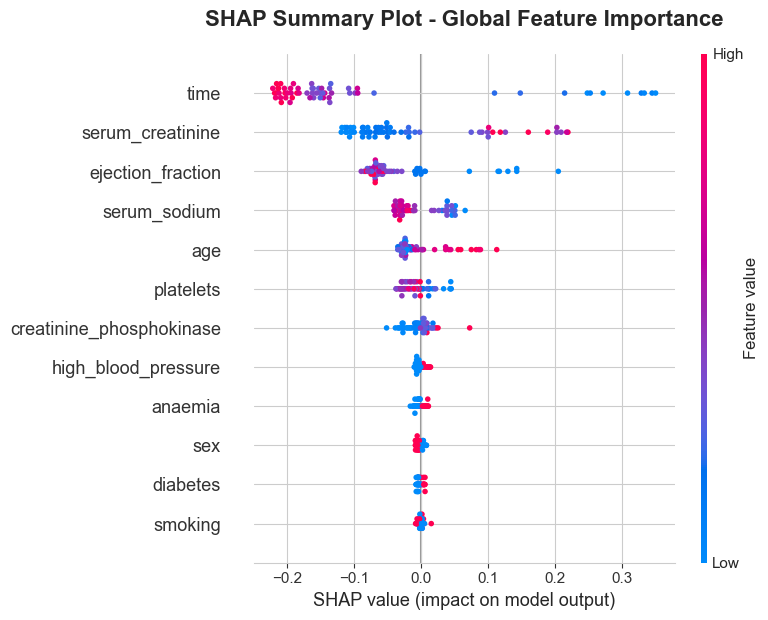


✓ Summary plot saved to: models/shap_summary_plot.png


In [5]:
print("SHAP SUMMARY PLOT - GLOBAL FEATURE IMPORTANCE")

print("\nThis plot shows:")
print("  • Most important features (top to bottom)")
print("  • How feature values impact predictions")
print("  • Red = high feature value, Blue = low feature value")
print("  • Right = increases death risk, Left = decreases death risk")

# Create summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_scaled, show=False)
plt.title('SHAP Summary Plot - Global Feature Importance', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('models/shap_summary_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nSummary plot saved to: models/shap_summary_plot.png")



Creating SHAP bar plot (mean absolute importance)...


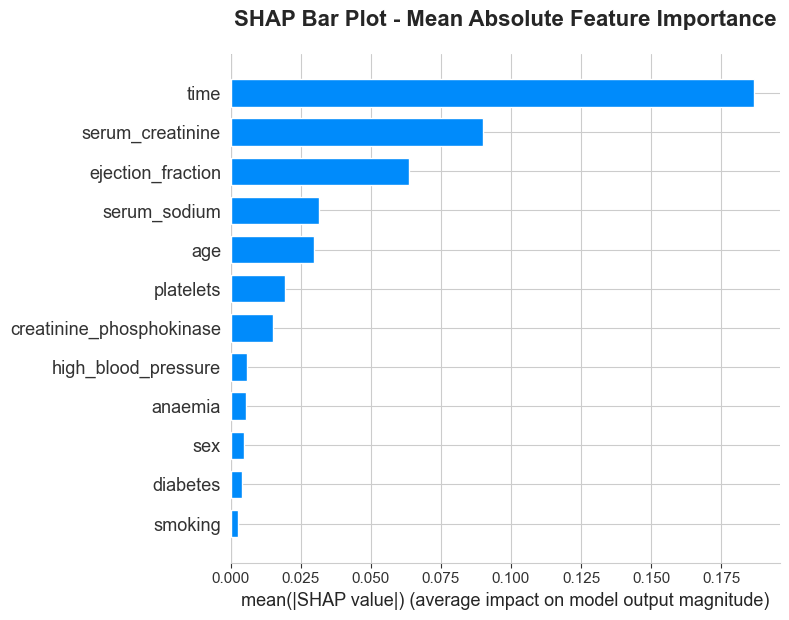

✓ Bar plot saved to: models/shap_bar_plot.png


In [6]:
# Alternative: Bar plot showing mean absolute SHAP values
print("\nCreating SHAP bar plot (mean absolute importance)")

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_scaled, plot_type="bar", show=False)
plt.title('SHAP Bar Plot - Mean Absolute Feature Importance', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('models/shap_bar_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("Bar plot saved to: models/shap_bar_plot.png")


## 5. SHAP Waterfall Plot (Individual Prediction Explanation)


In [7]:
print("SHAP WATERFALL PLOTS - INDIVIDUAL PREDICTION EXPLANATIONS")

# Get predictions for test set
y_pred = best_model.predict(X_test_scaled)
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Find interesting samples to explain
# 1. High-risk patient who died (True Positive)
high_risk_died = X_test_scaled[(y_test == 1) & (y_pred == 1)].index
if len(high_risk_died) > 0:
    sample_idx_tp = X_test_scaled.index.get_loc(high_risk_died[0])
else:
    sample_idx_tp = 0

# 2. Low-risk patient who survived (True Negative)
low_risk_survived = X_test_scaled[(y_test == 0) & (y_pred == 0)].index
if len(low_risk_survived) > 0:
    sample_idx_tn = X_test_scaled.index.get_loc(low_risk_survived[0])
else:
    sample_idx_tn = 1

# 3. Highest predicted risk
sample_idx_highest = np.argmax(y_pred_proba)

print(f"\nExplaining 3 sample predictions:")
print(f"  1. High-risk patient who died (index {sample_idx_tp})")
print(f"  2. Low-risk patient who survived (index {sample_idx_tn})")
print(f"  3. Highest predicted risk patient (index {sample_idx_highest})")



SHAP WATERFALL PLOTS - INDIVIDUAL PREDICTION EXPLANATIONS

Explaining 3 sample predictions:
  1. High-risk patient who died (index 11)
  2. Low-risk patient who survived (index 0)
  3. Highest predicted risk patient (index 33)



1. Waterfall Plot - High-Risk Patient Who Died
----------------------------------------------------------------------


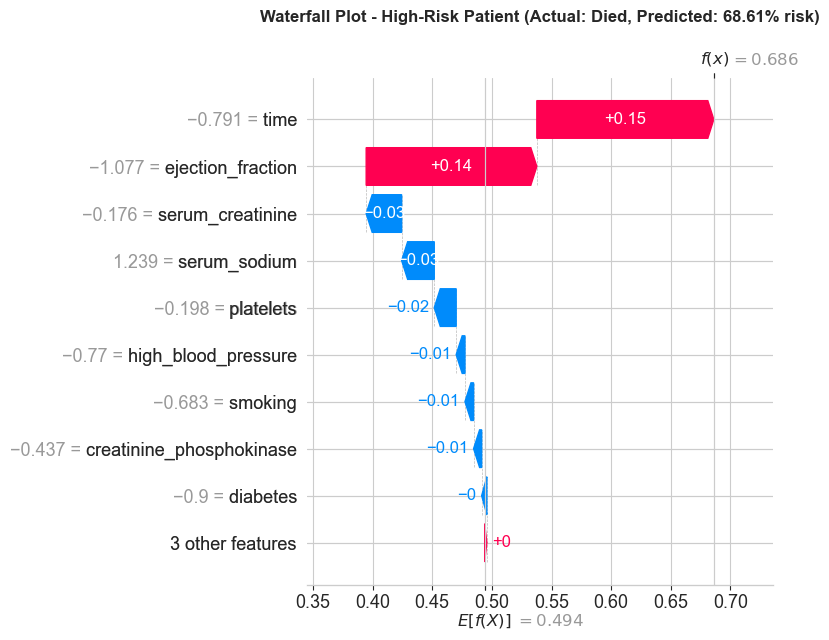

Actual outcome: Died
Predicted probability of death: 68.61%
✓ Waterfall plot saved to: models/shap_waterfall_high_risk.png


In [8]:
# Waterfall plot for high-risk patient who died
print("\n1. Waterfall Plot - High-Risk Patient Who Died")

# Create explanation object for waterfall plot
explanation = shap.Explanation(
    values=shap_values[sample_idx_tp],
    base_values=expected_value,
    data=X_test_scaled.iloc[sample_idx_tp].values,
    feature_names=X_test_scaled.columns.tolist()
)

plt.figure(figsize=(10, 8))
shap.waterfall_plot(explanation, show=False)
plt.title(f'Waterfall Plot - High-Risk Patient (Actual: Died, Predicted: {y_pred_proba[sample_idx_tp]:.2%} risk)', 
          fontsize=12, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('models/shap_waterfall_high_risk.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Actual outcome: Died")
print(f"Predicted probability of death: {y_pred_proba[sample_idx_tp]:.2%}")
print("Waterfall plot saved to: models/shap_waterfall_high_risk.png")



2. Waterfall Plot - Low-Risk Patient Who Survived
----------------------------------------------------------------------


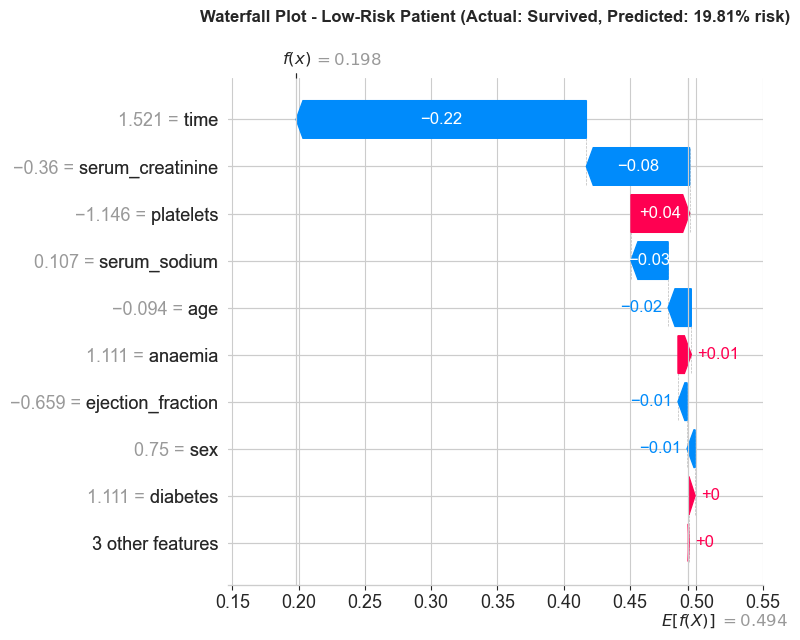

Actual outcome: Survived
Predicted probability of death: 19.81%
✓ Waterfall plot saved to: models/shap_waterfall_low_risk.png


In [9]:
# Waterfall plot for low-risk patient who survived
print("\n2. Waterfall Plot - Low-Risk Patient Who Survived")

explanation = shap.Explanation(
    values=shap_values[sample_idx_tn],
    base_values=expected_value,
    data=X_test_scaled.iloc[sample_idx_tn].values,
    feature_names=X_test_scaled.columns.tolist()
)

plt.figure(figsize=(10, 8))
shap.waterfall_plot(explanation, show=False)
plt.title(f'Waterfall Plot - Low-Risk Patient (Actual: Survived, Predicted: {y_pred_proba[sample_idx_tn]:.2%} risk)', 
          fontsize=12, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('models/shap_waterfall_low_risk.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Actual outcome: Survived")
print(f"Predicted probability of death: {y_pred_proba[sample_idx_tn]:.2%}")
print("Waterfall plot saved to: models/shap_waterfall_low_risk.png")



3. Waterfall Plot - Highest Predicted Risk Patient
----------------------------------------------------------------------


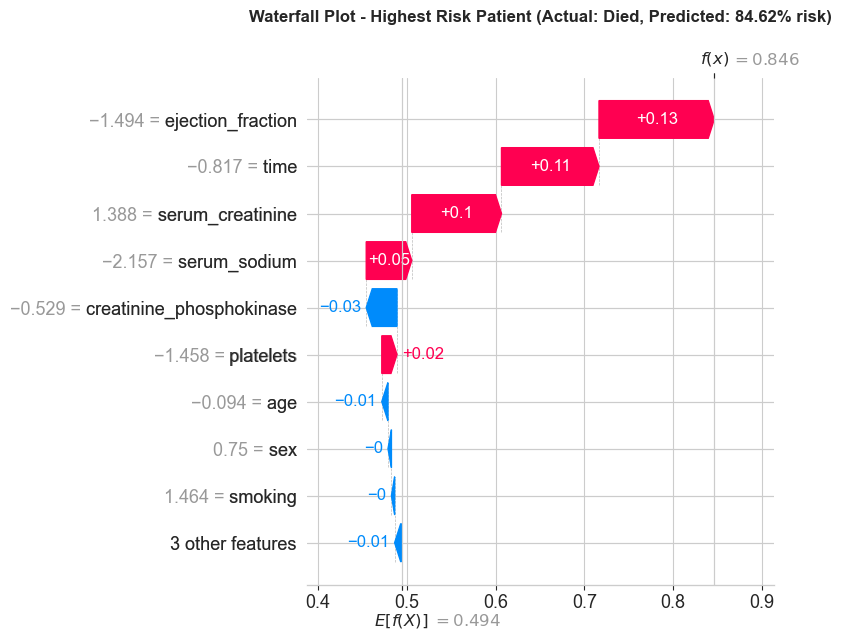

Actual outcome: Died
Predicted probability of death: 84.62%
✓ Waterfall plot saved to: models/shap_waterfall_highest_risk.png


In [10]:
# Waterfall plot for highest predicted risk
print("\n3. Waterfall Plot - Highest Predicted Risk Patient")

explanation = shap.Explanation(
    values=shap_values[sample_idx_highest],
    base_values=expected_value,
    data=X_test_scaled.iloc[sample_idx_highest].values,
    feature_names=X_test_scaled.columns.tolist()
)

plt.figure(figsize=(10, 8))
shap.waterfall_plot(explanation, show=False)
actual_outcome = "Died" if y_test.iloc[sample_idx_highest] == 1 else "Survived"
plt.title(f'Waterfall Plot - Highest Risk Patient (Actual: {actual_outcome}, Predicted: {y_pred_proba[sample_idx_highest]:.2%} risk)', 
          fontsize=12, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('models/shap_waterfall_highest_risk.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Actual outcome: {actual_outcome}")
print(f"Predicted probability of death: {y_pred_proba[sample_idx_highest]:.2%}")
print("Waterfall plot saved to: models/shap_waterfall_highest_risk.png")


## 6. SHAP Dependence Plots (Feature Interactions)



SHAP DEPENDENCE PLOTS - FEATURE INTERACTIONS

Creating dependence plots for top 4 features:
  1. time
  2. serum_creatinine
  3. ejection_fraction
  4. serum_sodium


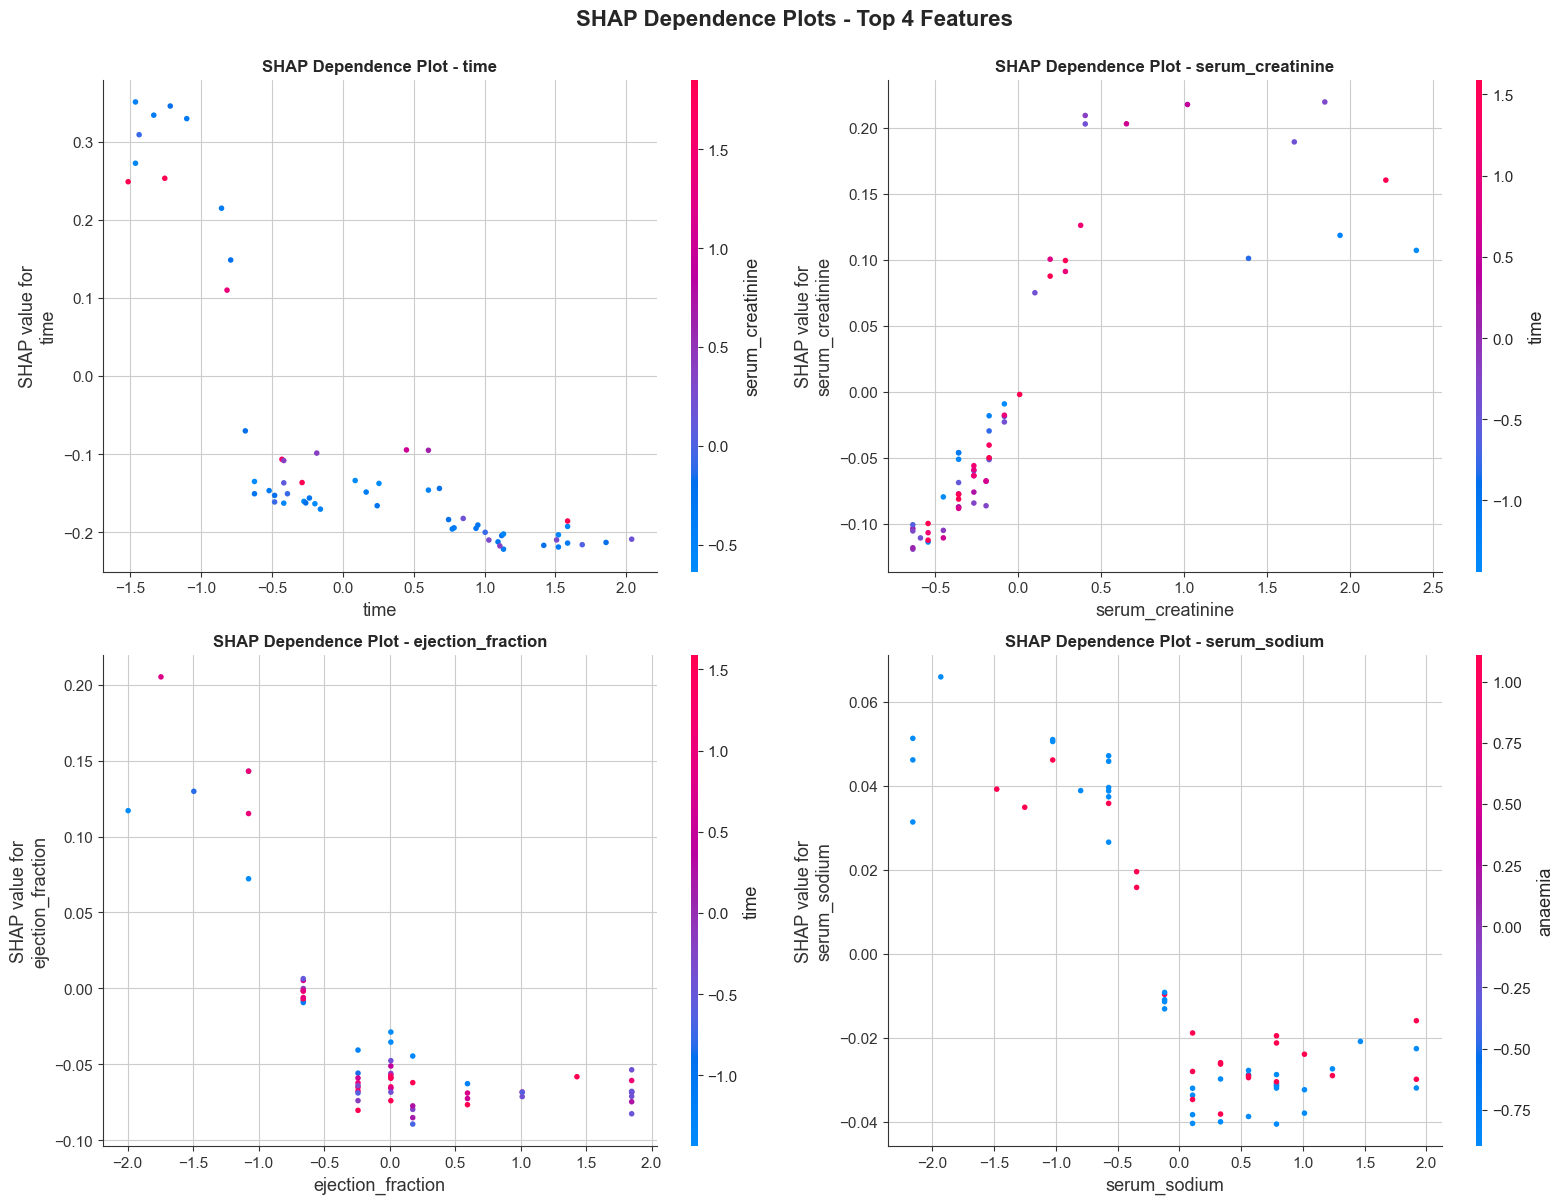


✓ Dependence plots saved to: models/shap_dependence_plots.png


In [11]:
print("SHAP DEPENDENCE PLOTS - FEATURE INTERACTIONS")

# Get top 4 most important features
feature_importance = np.abs(shap_values).mean(axis=0)
top_features_idx = np.argsort(feature_importance)[::-1][:4]
top_features = [X_test_scaled.columns[i] for i in top_features_idx]

print(f"\nCreating dependence plots for top 4 features:")
for i, feat in enumerate(top_features, 1):
    print(f"  {i}. {feat}")

# Create dependence plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, feature in enumerate(top_features):
    plt.sca(axes[idx])
    shap.dependence_plot(
        feature, 
        shap_values, 
        X_test_scaled,
        show=False,
        ax=axes[idx]
    )
    axes[idx].set_title(f'SHAP Dependence Plot - {feature}', fontsize=12, fontweight='bold')

plt.suptitle('SHAP Dependence Plots - Top 4 Features', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('models/shap_dependence_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nDependence plots saved to: models/shap_dependence_plots.png")


## 7. SHAP Force Plots (Alternative Visualization)


In [12]:
print("SHAP FORCE PLOTS - INDIVIDUAL PREDICTIONS")

# Initialize JavaScript visualization
shap.initjs()

# Force plot for high-risk patient
print("\nGenerating force plot for high-risk patient...")
force_plot = shap.force_plot(
    expected_value,
    shap_values[sample_idx_tp],
    X_test_scaled.iloc[sample_idx_tp],
    matplotlib=True,
    show=False
)
plt.savefig('models/shap_force_plot_high_risk.png', dpi=300, bbox_inches='tight')
plt.close()

print("Force plot saved to: models/shap_force_plot_high_risk.png")



SHAP FORCE PLOTS - INDIVIDUAL PREDICTIONS



Generating force plot for high-risk patient...
✓ Force plot saved to: models/shap_force_plot_high_risk.png


## 8. Save SHAP Explainer and Values


In [13]:
print("\n" + "=" * 70)
print("SAVING SHAP ARTIFACTS FOR DASHBOARD")
print("=" * 70)

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save the SHAP explainer
explainer_path = 'models/shap_explainer.pkl'
joblib.dump(explainer, explainer_path)
print(f"\n✓ SHAP explainer saved to: {explainer_path}")

# Save SHAP values for test set
shap_values_dict = {
    'shap_values': shap_values,
    'expected_value': expected_value,
    'feature_names': X_test_scaled.columns.tolist(),
    'test_data': X_test_scaled.values,
    'test_indices': X_test_scaled.index.tolist()
}
shap_values_path = 'models/shap_values.pkl'
joblib.dump(shap_values_dict, shap_values_path)
print(f"✓ SHAP values saved to: {shap_values_path}")

# Save feature importance summary
feature_importance_df = pd.DataFrame({
    'feature': X_test_scaled.columns,
    'mean_abs_shap': np.abs(shap_values).mean(axis=0),
    'mean_shap': shap_values.mean(axis=0)
}).sort_values('mean_abs_shap', ascending=False)

importance_path = 'models/shap_feature_importance.csv'
feature_importance_df.to_csv(importance_path, index=False)
print(f"✓ Feature importance saved to: {importance_path}")

print(f"\nFile sizes:")
print(f"  - Explainer: {os.path.getsize(explainer_path)} bytes")
print(f"  - SHAP values: {os.path.getsize(shap_values_path)} bytes")
print(f"  - Feature importance: {os.path.getsize(importance_path)} bytes")



SAVING SHAP ARTIFACTS FOR DASHBOARD

✓ SHAP explainer saved to: models/shap_explainer.pkl
✓ SHAP values saved to: models/shap_values.pkl
✓ Feature importance saved to: models/shap_feature_importance.csv

File sizes:
  - Explainer: 434613 bytes
  - SHAP values: 12256 bytes
  - Feature importance: 688 bytes
